In [2]:
import sys
import os

import numpy as np
import sklearn

import matplotlib as mpl
import matplotlib.pyplot as plt



# MNIST

* Fetch the **MNIST** dataset **Mixed National Institute of Standards and Technology**

In [3]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784',version=1,as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [5]:
mnist['data']

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [6]:
mnist['DESCR']

"**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  \n**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  \n**Please cite**:  \n\nThe MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  \n\nIt is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 

In [7]:
X, y =mnist['data'],mnist['target']
X.shape

(70000, 784)

In [8]:
y.shape

(70000,)

* 70,000 images with 784 features each representing a 28x28 pixel grid with a pixel intensity ranging from 0 to 255.

In [29]:
len(X[0])

784

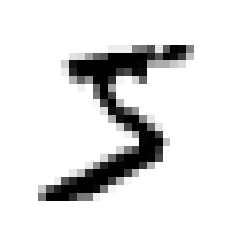

In [11]:
some_digit = X[0]#array representation of a number
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image,cmap=mpl.cm.binary)
plt.axis('off')

plt.show()

In [12]:
y[0]

'5'

In [15]:
y = y.astype(np.uint8)
y

array([5, 0, 4, ..., 4, 5, 6], dtype=uint8)

* Setting aside our test set. In this dataset they were already gathered as being the last 10,000 observations.

In [16]:
X_train, X_test, y_train, y_test = X[:60000],X[60000:],y[:60000],y[60000:]

# Training a Binary Classifier

We simplify the problem by focusing on a **binary classifier**, trying to detect whether it's a **5** or a **non-5** (2 classes).

In [17]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

* We start by training a Stochastic Gradient Descent (SGD) classifier.

In [20]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

* We use it to detect images of the number 5

In [21]:
sgd_clf.predict([some_digit])

array([ True])

=> The classifier guesses that the image represents a 5.

# Performance measures

* Evaluating a classifier is trickier than evaluating a regressor.

## Measuring accuracy using Cross-Validation

### Stratified K-Folds

Performs stratified sampling to produce folds with representative ratio of each class.

In [22]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3,shuffle=True,random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))

0.9669
0.91625
0.96785


### Cross-Validation

In [23]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

* more than 95% accuracy on all folds

### Dumb Classifier

Classify as not-5 every single image

In [24]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X),1),dtype=bool)

In [26]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

## Confusion Matrix

Confusion Matrix is a better way to evaluate the performance of a classifier. (count the number of times instances of class A are classified as class B).

* we need a set of predictions to compute the confusion matrix. We will use it on our train set to save the test one.

In [30]:
from sklearn.model_selection import cross_val_predict

#returns a set of predictions after performing K-folds cross-validation
y_train_pred = cross_val_predict(sgd_clf,X_train, y_train_5, cv=3)

In [32]:
len(y_train_pred)

60000

* Confusion Matrix

In [33]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

Each row represents an **actual class** while each column represents a **predicted class**

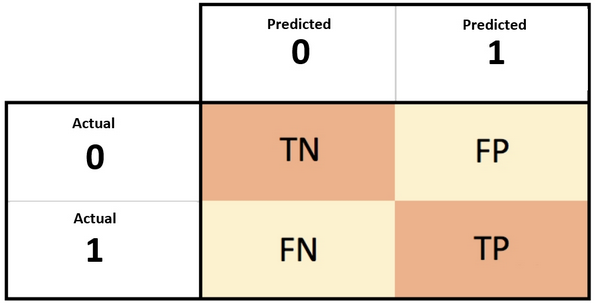

In [41]:
## Ipython image of confusion matrix
from IPython.display import Image 
Image("media\\matrix.png")

* First row considers non-5 images
    * 53892 correctly classified as non-5 (**T**rue **N**egatives)
    * The rest was wrongly classifeif as 5s (**F**alse **P**ositives)
    
* Second row considers 5 images
    * 1891 wrongly classified as non-5 (**F**alse **N**egatives)
    * 3530 correctly classified as 5s (**T**rue **P**ositives)

* A perfect classifier would have only True Positives and True Negatives

In [34]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

### Precision & Recall

* Accuracy of the positive predictions : **Precision**. Out of the total Positive predicted by the model, what is the % of actual positive results.

**Precision** answers the question : What is the proportion of positive identifications correctly guessed.

$Precision = \frac{TP}{TP+FP}$

TP : number of True Positives  
FP : number of False Positives

* Precision is used with another metric called **Recall** (**Sensitivity** or TPR for **True Positive Rate**)

**Recall** answers the question : What is the proportion of real positive results correctly identified.

$Recall = \frac{TP}{TP+FN}$

FN : Number of false Negatives

In [42]:
# precision score
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5,y_train_pred)

0.8370879772350012

In [44]:
# precision alternative
cm = confusion_matrix(y_train_5,y_train_pred)
cm[1,1] / (cm[0,1]+cm[1,1])

0.8370879772350012

In [43]:
# recall score
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [46]:
# recall alternative
cm[1,1] / (cm[1,1]+cm[1,0])

0.6511713705958311

* When the model claims an image represents 5, it is correct 83% of the time (Precision)
* The model detects 65% of the 5s (recall)

### F1 Score

We can combine **Precision** and  **Recall** in a single metric called the ${F}_{1}$ score. 
* ${F}_{1}$ is a **<i>harmonic mean</i>** of precision and recall, it's a mean that gives much more weight to low values.  
=> The classifier will only get a high ${F}_{1}$ if both recall and precision are high.

${F}_{1} = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} = 2 x \frac{precision * recall}{precision + Recall} = \frac{TP}{TP + \frac{FN + FP}{2}}$

In [47]:
# F1 Score in python
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [48]:
# F1 Score alternative
cm[1,1]/(cm[1,1] + (cm[1,0] + cm[0,1])/2)

0.7325171197343847

Increasing precision reduces recall and vice versa. This is known as **Precision/Recall Tradeoff**

## Precision vs Recall : Intuition

**Recall**  
Models need high recall when you need output-sensitive predictions. For example, predicting cancer or predicting terrorists needs a high recall, in other words, you need to cover false negatives as well. It is ok if a non-cancer tumor is flagged as cancerous but a cancerous tumor should not be labeled non-cancerous.

**Precision**  
Similarly, we need high precision in places such as recommendation engines, spam mail detection, etc. Where you don’t care about false negatives but focus more on true positives and false positives. It is ok if spam comes into the inbox folder but a really important mail shouldn’t go into the spam folder.

### Precision/Recall TradeOff

Scikit learn doesn't allow setting the threshold directly but guves access to the decision score used to predict the model.

todo : https://www.geeksforgeeks.org/ml-decision-function/

In [49]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [50]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [51]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

* The image represents a **5**. The classifier detects it when the threshold is set to 0 but not when it's set to 8000.  

=> Increasing the threshold decreases the recall

* How to decide which threshold to use ?  


In [52]:
# get the scores of all instances using the cross_val_predict() with the decision function param
y_scores = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method='decision_function')


In [53]:
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

* We compute precision and recall for all possible thresholds

In [54]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

* We plot precision and recall as functions of the threshold

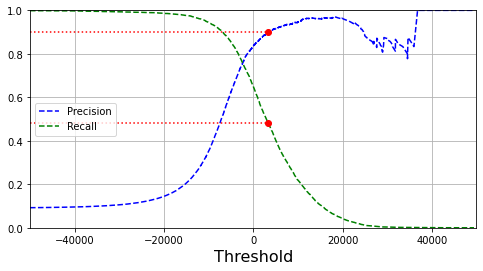

In [70]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1],"b--",label='Precision')
    plt.plot(thresholds, recalls[:-1],'g--',label='Recall')
    plt.xlabel("Threshold",fontsize=16)
    plt.legend(loc='center left')
    plt.grid(True) 
    plt.ylim([0,1])
    plt.axis([-50000, 50000, 0, 1])
    
# draw a 90% intersection point
recall_90_precision = recalls[np.argmax(precisions >=0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]
    
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

plt.plot([threshold_90_precision,threshold_90_precision],[0.9,0.9],'r:')
#draw the lines
plt.plot([-50000,threshold_90_precision],[0.9,0.9],'r:')
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
# draw the points
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro") 

* Precision curve can get bumpier cause the precision may go down when we raise the threshold.
* Recall can only can only go down with a higher threshold, hence the smooth curve

* Another way to select a good threshold value is by plotting precision against recall

ERROR! Session/line number was not unique in database. History logging moved to new session 3839


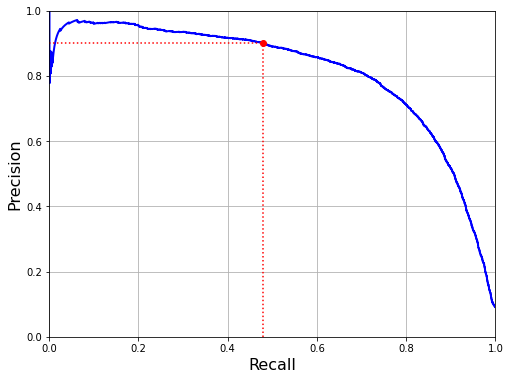

In [71]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions,"b-",linewidth=2)
    plt.xlabel('Recall', fontsize=16)
    plt.ylabel('Precision', fontsize=16)
    plt.axis([0,1,0,1])# ???
    plt.grid(True)
    
plt.figure(figsize=(8,6))
plot_precision_vs_recall(precisions, recalls)
# draw lines
plt.plot([recall_90_precision, recall_90_precision],[0.,0.9],'r:')
plt.plot([0.0,recall_90_precision],[0.9,0.9],'r:')
# draw the point
plt.plot([recall_90_precision],[0.9],'ro')


* Precision starts brutally sinking around 80% recall. The sweet spot would be around 60% depending on our needs.

Let's suppose we aim for a 90% precision, we identify the target threshold

In [72]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]
threshold_90_precision

3370.0194991439557

We use this threshold to make predictions

In [73]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [74]:
precision_score(y_train_5,y_train_pred_90)

0.9000345901072293

In [75]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

We get a 90% precision classifier. A high precision classifier is not very useful if its recall is too low.